# Data Sources

Get data 

## import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

## definitions

In [2]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2021-01-01 00:00:00"
LAST_DATE =  "2023-02-19 23:00:00"
TIMEFRAME = "1h"
PATH_DATA = "data"
path_save_df_eth = "data/df_eth.csv"
path_save_df_eth_2 = "data/df_eth_2.csv"
path_save_df_btc = "data/df_btc.csv"
path_save_df_btc_2 = "data/df_btc_2.csv"
path_save_df_bnb = "data/df_bnb.csv"
path_save_df_bnb_2 = "data/df_bnb_2.csv"
path_save_df_eco = "data/df_eco.csv"
path_save_df_feat = "data/df_feat.csv"

# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})


## Download data

In [3]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE

# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp, params= { 'until': to_timestamp})
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            from_timestamp += len(ohlcvs) * hour
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms') # -> date object
    df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except:
        
        return False




    
def req_ohlcv_all(exchange, first_date=FIRST_DATE, last_date=LAST_DATE):

    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        first_date,  
        last_date,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    return df_eth, df_btc, df_bnb

def merge_ohlcv_data(df_old, df_new):

    # Merge old with new data 
    df = pd.concat([df_old, df_new], ignore_index=True)
    print("df_old.shape: ", df_old.shape)
    print("df_new.shape: ", df_new.shape)
    print("Before : df.shape: ", df.shape)
    df = df.drop_duplicates(
        subset=["date"], keep="last", ignore_index=True)
    print("After : df.shape: ", df.shape)
    return df



def get_ohlcv_all(exchange, path_save_df_eth, path_save_df_btc, path_save_df_bnb):
    """
    Get prices from disk and from exchange if update needed
    """
    # reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)
    
    return df_eth, df_btc, df_bnb

In [4]:
data_ok = check_data()
print(data_ok)

if not data_ok:
    
    df_eth, df_btc, df_bnb = req_ohlcv_all(exchange)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:

    df_eth, df_btc, df_bnb = get_ohlcv_all(
        exchange,
        path_save_df_eth,
        path_save_df_btc,
        path_save_df_bnb
    )
    '''# reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)'''
        

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

True
Reload data binance exchange from disk...
New data to download...
1676847915250 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847918541 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
1676847918546 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847919627 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
1676847919630 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847920559 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
df_old.shape:  (18705, 7)
df_new.shape:  (3, 7)
Before : df.shape:  (18708, 7)
After : df.shape:  (18707, 7)
df_old.shape:  (18705, 7)
df_new.shape:  (3, 7)
Before : df.shape:  (18708, 7)
After : df.shape:  (18707, 7)
df_old.shape:  (18705, 7)
df_new.shape:  (3, 7)
Before : df.

In [5]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18702,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00
18703,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00
18704,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00
18705,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00


In [6]:

data_ok_2 = check_data_2()

if not data_ok_2:

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    print("Reload data kucoin exchange from disk...")

    df_eth_2, df_btc_2, df_bnb_2 = get_ohlcv_all(
        exchange,
        path_save_df_eth_2,
        path_save_df_btc_2,
        path_save_df_bnb_2,
    )
    '''# reload from disk
    
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False) 
    '''

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
Reload data binance exchange from disk...
New data to download...
1676847934119 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847934775 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
1676847934776 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847935804 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
1676847935805 Fetching candles starting from 2023-02-19T21:00:00.000Z
1676847936353 Fetched 3 candles
First candle epoch 1676840400000 2023-02-19T21:00:00.000Z
Last candle epoch 1676847600000 2023-02-19T23:00:00.000Z
df_old.shape:  (18718, 7)
df_new.shape:  (3, 7)
Before : df.shape:  (18721, 7)
After : df.shape:  (18720, 7)
df_old.shape:  (18718, 7)
df_new.shape:  (3, 7)
Before : df.shape:  (18721, 7)
After : df.shape:  (18720, 7)
df_old.shape:  (18718, 7

In [7]:
df_eth_2

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,736.14,738.80,729.61,734.06,583.786719,2021-01-01 00:00:00
1,1609462800000,734.03,748.88,733.44,748.70,1262.473819,2021-01-01 01:00:00
2,1609466400000,748.31,748.90,742.27,744.20,883.894157,2021-01-01 02:00:00
3,1609470000000,744.03,747.18,743.32,744.86,403.482930,2021-01-01 03:00:00
4,1609473600000,745.36,747.05,739.73,742.50,644.383020,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.928200,2023-02-19 19:00:00
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.411400,2023-02-19 20:00:00
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.474800,2023-02-19 21:00:00
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.943700,2023-02-19 22:00:00


In [8]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18702,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00
18703,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00
18704,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00
18705,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00


In [9]:
test_time_continuity(df_eth)

False

In [10]:
test_time_continuity(df_eth_2)

True

In [11]:
def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

In [12]:
def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missage dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in abosolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df

In [13]:
df_eth = fill_time_gap(df_eth, df_eth_2)
df_btc = fill_time_gap(df_btc, df_btc_2)
df_bnb = fill_time_gap(df_bnb, df_bnb_2)

Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volum

In [14]:
test_time_continuity(df_eth) and test_time_continuity(df_btc) and test_time_continuity(df_bnb) 

True

## Add price action indicators

Ichimoku 1h 1D 1W

In [15]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_a_week"].ffill(inplace=True)
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()
    
    return df_out

df_eth = add_ichimoku(df_eth)
df_btc = add_ichimoku(df_btc)

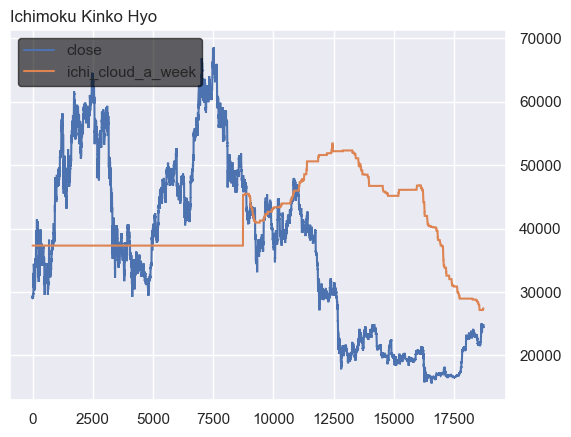

In [16]:
plt.plot(df_btc.Close, label="close")
plt.plot(df_btc["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

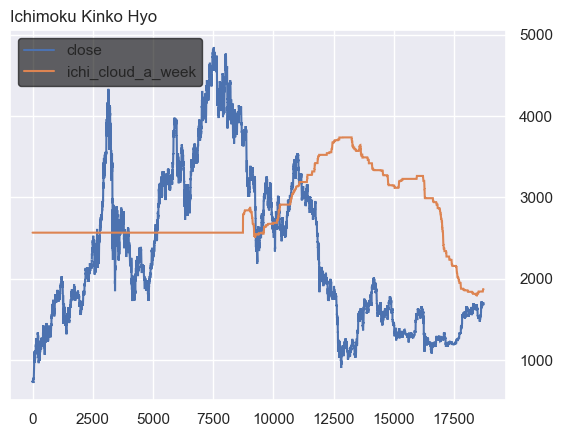

In [17]:
plt.plot(df_eth.Close, label="close")
plt.plot(df_eth["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

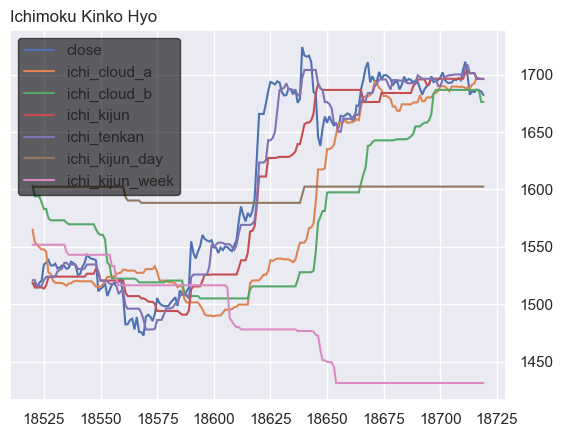

In [18]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [19]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=n*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=n*24*7).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_btc = add_rsi(df_btc)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,2328.404628,NaN,NaN,2566.463724,2550.692681,NaN,NaN,NaN,NaN,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,2328.404628,NaN,NaN,2566.463724,2550.692681,NaN,NaN,NaN,NaN,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,2328.404628,NaN,NaN,2566.463724,2550.692681,NaN,NaN,NaN,NaN,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,2328.404628,NaN,NaN,2566.463724,2550.692681,NaN,NaN,NaN,NaN,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,2328.404628,NaN,NaN,2566.463724,2550.692681,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,1414.885000,1602.45,1602.45,1872.475000,2874.780000,1431.265,1446.74,43.868635,52.508605,50.504412
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,1414.885000,1602.45,1602.45,1872.475000,2874.780000,1431.265,1446.74,42.682786,52.444931,50.496710
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,1414.885000,1602.45,1602.45,1872.475000,2874.780000,1431.265,1446.74,42.326939,52.426516,50.494485
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,1414.885000,1602.45,1602.45,1872.475000,2874.780000,1431.265,1446.74,43.618903,52.469238,50.500054


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [20]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        #(high: pandas.core.series.Series, 
        # low: pandas.core.series.Series, 
        # close: pandas.core.series.Series, 
        # window: int = 14, 
        # fillna: bool = False)
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high = df_out["High"].rolling(n*k).max()
        min_low = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n*k)
        return chop, atr, max_high, min_low
    
    
    def  add_chop_col(df_out, n, k):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        if k == 1:
            df_out["max_high_h"] = max_high
            df_out["min_low_h"] = min_low
            df_out["atr_h"] = atr
            df_out["chop_h"] = chop
        elif (k==24):
            df_out["max_high_d"] = max_high
            df_out["min_low_d"] = min_low
            df_out["atr_d"] = atr
            df_out["chop_d"] = chop   
        elif (k==24*7):
            df_out["max_high_w"] = max_high
            df_out["min_low_w"] = min_low
            df_out["atr_w"] = atr
            df_out["chop_w"] = chop  
        else:
            df_out[f"max_high_{k}"] = max_high
            df_out[f"min_low_{k}"] = min_low
            df_out[f"atr_{k}"] = atr
            df_out[f"chop_{k}"] = chop
        return df_out                       
    # 1h
    df_out = add_chop_col(df_out, n, 1)
    # 1day
    df_out = add_chop_col(df_out, n, 24)    
    # 1week
    df_out = add_chop_col(df_out, n, 24*7)

    return df_out

df_eth = add_chop(df_eth, 14)
df_btc = add_chop(df_btc, 14)
df_eth[["date", "High", "Low", "Close", 
         "atr_h", "max_high_h","min_low_h", "chop_h",
         "atr_d", "max_high_d","min_low_d", "chop_d",
         "atr_w", "max_high_w","min_low_w", "chop_w"]].tail(30)


,date,High,Low,Close,atr_h,max_high_h,min_low_h,chop_h,atr_d,max_high_d,min_low_d,chop_d,atr_w,max_high_w,min_low_w,chop_w
18690,2023-02-18 18:00:00,1713.13,1687.52,1693.58,25.61,1713.13,1685.69,54.356315,12.752275,1742.97,1461.93,46.810021,13.383990,1742.97,1075.0,47.498235
18691,2023-02-18 19:00:00,1695.00,1682.80,1687.85,12.20,1713.13,1682.80,53.112591,12.729264,1742.97,1461.93,46.814068,13.376943,1742.97,1075.0,47.492700
18692,2023-02-18 20:00:00,1688.27,1679.77,1682.58,8.50,1713.13,1679.77,50.724131,12.553044,1742.97,1461.93,46.817657,13.347913,1742.97,1075.0,47.487209
18693,2023-02-18 21:00:00,1687.59,1681.81,1687.43,5.78,1713.13,1679.77,49.436750,12.270834,1742.97,1461.93,46.821129,13.302866,1742.97,1075.0,47.481721
18694,2023-02-18 22:00:00,1691.80,1686.26,1689.97,5.54,1713.13,1679.77,49.065193,11.990383,1742.97,1461.93,46.823455,13.256659,1742.97,1075.0,47.476255
18695,2023-02-18 23:00:00,1693.71,1688.20,1691.62,5.51,1713.13,1679.77,49.795543,11.720367,1742.97,1461.93,46.822452,13.210548,1742.97,1075.0,47.470796
18696,2023-02-19 00:00:00,1700.62,1689.76,1698.71,10.86,1713.13,1679.77,50.482121,11.684518,1742.97,1461.93,46.821049,13.196556,1742.97,1075.0,47.465360
18697,2023-02-19 01:00:00,1700.00,1689.50,1693.53,10.50,1713.13,1679.77,51.551912,11.635163,1742.97,1461.93,46.820315,13.180505,1742.97,1075.0,47.459957
18698,2023-02-19 02:00:00,1698.06,1693.07,1694.30,4.99,1713.13,1679.77,49.189450,11.358282,1742.97,1461.93,46.819146,13.131752,1742.97,1075.0,47.454579
18699,2023-02-19 03:00:00,1698.20,1693.57,1695.42,4.63,1713.13,1679.77,48.636496,11.077936,1742.97,1461.93,46.817657,13.081147,1742.97,1075.0,47.449217


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price

In [21]:
# VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=1):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=14,
        fillna=True,
        ).volume_weighted_average_price()
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 6months
    df_out["vwap_6m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*6).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth)
df_btc = add_vwap(df_btc)
df_eth


,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,atr_w,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,0.000000,NaN,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,0.000000,NaN,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,0.000000,NaN,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,0.000000,NaN,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,0.000000,NaN,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,12.927339,47.364659,1698.117794,1697.237731,1612.360136,1481.323268,2188.054792,2111.076664,1678.918304,2111.076664
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,12.979379,47.359626,1696.390495,1696.360207,1612.922937,1481.340579,2188.000699,2111.056629,1678.890186,2111.056629
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,12.932299,47.354530,1695.960081,1696.120682,1613.918683,1481.328420,2187.972888,2111.047664,1678.854499,2111.047664
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,12.897583,47.349440,1695.739708,1696.007965,1615.226400,1481.219019,2187.949432,2111.042320,1678.829900,2111.042320


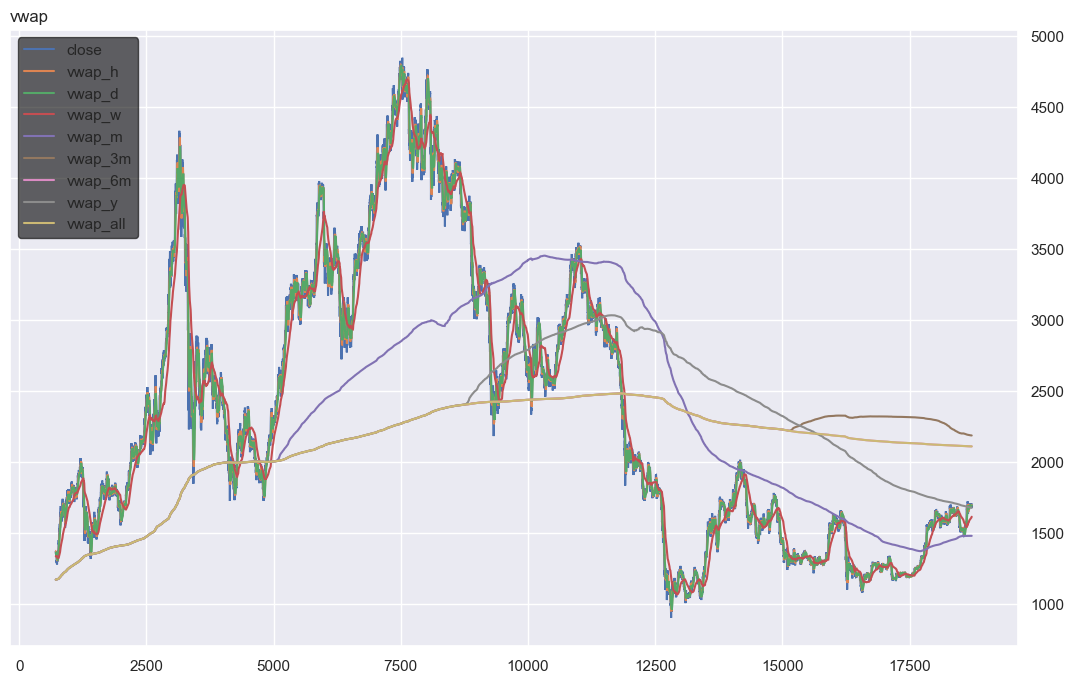

In [22]:
nb_point = 18000
fig = plt.figure()
fig.set_size_inches([13,8])
plt.plot(df_eth[-nb_point:].Close, label="close")
plt.plot(df_eth[-nb_point:]["vwap_h"], label='vwap_h')
plt.plot(df_eth[-nb_point:]["vwap_d"], label='vwap_d')
plt.plot(df_eth[-nb_point:]["vwap_w"], label='vwap_w')
plt.plot(df_eth[-nb_point:]["vwap_m"], label='vwap_m')
plt.plot(df_eth[-nb_point:]["vwap_3m"], label='vwap_3m')
plt.plot(df_eth[-nb_point:]["vwap_6m"], label='vwap_6m')
plt.plot(df_eth[-nb_point:]["vwap_y"], label='vwap_y')
plt.plot(df_eth[-nb_point:]["vwap_all"], label='vwap_all')
plt.title('vwap')
plt.legend()
plt.show()

- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [23]:
# MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
# nb_max_period = df_eth.shape[0]

df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_btc["vwap_z_score"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,NaN,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,NaN,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,NaN,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,NaN,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,NaN,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,47.364659,1698.117794,1697.237731,1612.360136,1481.323268,2188.054792,2111.076664,1678.918304,2111.076664,-0.434231
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,47.359626,1696.390495,1696.360207,1612.922937,1481.340579,2188.000699,2111.056629,1678.890186,2111.056629,-0.432006
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,47.354530,1695.960081,1696.120682,1613.918683,1481.328420,2187.972888,2111.047664,1678.854499,2111.047664,-0.433023
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,47.349440,1695.739708,1696.007965,1615.226400,1481.219019,2187.949432,2111.042320,1678.829900,2111.042320,-0.433452


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [24]:
# NUPL 
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_btc["nupl"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"]
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,1698.117794,1697.237731,1612.360136,1481.323268,2188.054792,2111.076664,1678.918304,2111.076664,-0.434231,-0.253013
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,1696.390495,1696.360207,1612.922937,1481.340579,2188.000699,2111.056629,1678.890186,2111.056629,-0.432006,-0.251390
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,1695.960081,1696.120682,1613.918683,1481.328420,2187.972888,2111.047664,1678.854499,2111.047664,-0.433023,-0.252126
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,1695.739708,1696.007965,1615.226400,1481.219019,2187.949432,2111.042320,1678.829900,2111.042320,-0.433452,-0.252435


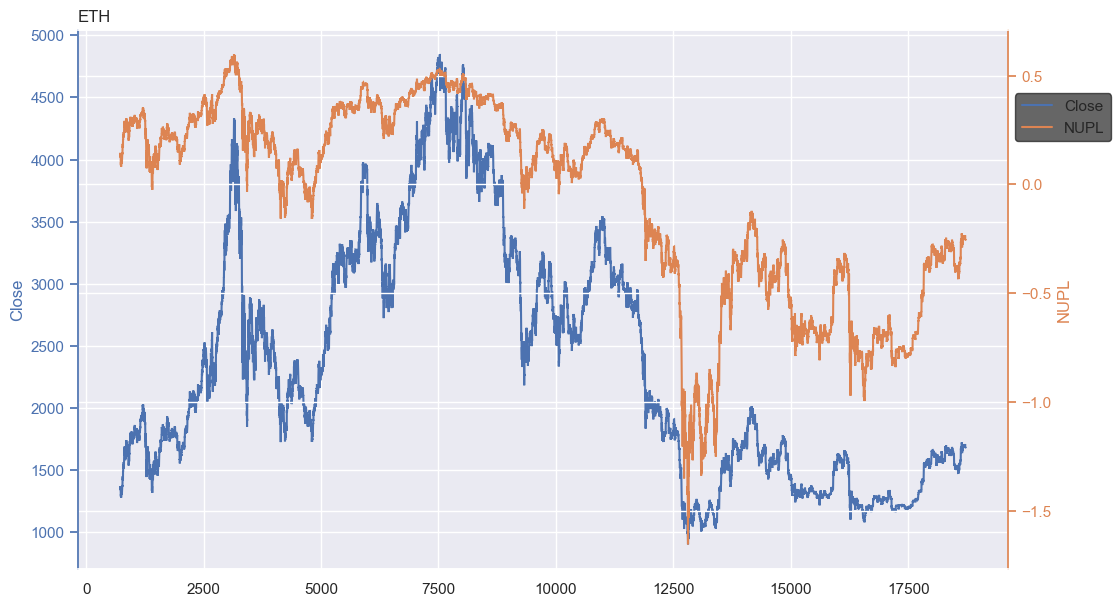

In [25]:
nb_point = 18000



fig, ax1 = plt.subplots()
fig.set_size_inches([12,7])
ax1.plot(df_eth[-nb_point:].Close)
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title('ETH')

ax2 = ax1.twinx()
ax2.plot(df_eth[-nb_point:]["nupl"],'C1')
ax2.set_ylabel('NUPL', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(['Close','NUPL'], bbox_to_anchor=(0.9, 0.8))

plt.show()

## Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [26]:
# https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086,94.0,Extreme Greed
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700,94.0,Extreme Greed
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195,94.0,Extreme Greed
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604,94.0,Extreme Greed
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080,94.0,Extreme Greed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,1612.360136,1481.323268,2188.054792,2111.076664,1678.918304,2111.076664,-0.434231,-0.253013,60.0,Greed
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,1612.922937,1481.340579,2188.000699,2111.056629,1678.890186,2111.056629,-0.432006,-0.251390,60.0,Greed
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,1613.918683,1481.328420,2187.972888,2111.047664,1678.854499,2111.047664,-0.433023,-0.252126,60.0,Greed
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,1615.226400,1481.219019,2187.949432,2111.042320,1678.829900,2111.042320,-0.433452,-0.252435,60.0,Greed


In [27]:
df_eth.head(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086,94.0,Extreme Greed
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700,94.0,Extreme Greed
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195,94.0,Extreme Greed
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604,94.0,Extreme Greed
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080,94.0,Extreme Greed
5,1609477200000,742.34,743.23,739.50,740.65,14948.26447,2021-01-01 05:00:00,2322.297304,2314.547318,NaN,...,742.130615,742.130615,742.130615,742.130615,742.130615,742.130615,-0.307873,-0.001999,94.0,Extreme Greed
6,1609480800000,740.72,743.25,737.04,739.97,17106.99495,2021-01-01 06:00:00,2322.297304,2314.547318,NaN,...,741.938223,741.938223,741.938223,741.938223,741.938223,741.938223,-0.439114,-0.002660,94.0,Extreme Greed
7,1609484400000,739.87,740.51,734.40,737.38,21624.68945,2021-01-01 07:00:00,2322.297304,2314.547318,NaN,...,741.458849,741.458849,741.458849,741.458849,741.458849,741.458849,-0.914077,-0.005532,94.0,Extreme Greed
8,1609488000000,737.37,738.48,725.10,730.07,52992.04892,2021-01-01 08:00:00,2322.297304,2314.547318,NaN,...,739.341687,739.341687,739.341687,739.341687,739.341687,739.341687,-1.644503,-0.012700,94.0,Extreme Greed
9,1609491600000,730.07,734.77,728.77,733.68,22836.46973,2021-01-01 09:00:00,2322.297304,2314.547318,NaN,...,738.774446,738.774446,738.774446,738.774446,738.774446,738.774446,-0.893959,-0.006944,94.0,Extreme Greed


In [28]:
df_eth.tail(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
18695,1676761200000,1689.97,1693.71,1688.20,1691.62,5519.0365,2023-02-18 23:00:00,1680.1500,1660.235,1691.425,...,1601.161858,1481.445215,2188.900770,2111.304286,1680.002707,2111.304286,-0.427381,-0.248096,60.0,Greed
18696,1676764800000,1691.62,1700.62,1689.76,1698.71,10021.4209,2023-02-19 00:00:00,1680.1500,1665.695,1696.450,...,1601.601322,1481.435472,2188.879021,2111.297383,1679.941110,2111.297383,-0.420160,-0.242883,60.0,Greed
18697,1676768400000,1698.70,1700.00,1689.50,1693.53,10670.5640,2023-02-19 01:00:00,1683.1575,1683.610,1696.450,...,1601.971474,1481.433094,2188.862306,2111.289997,1679.877508,2111.289997,-0.425435,-0.246680,60.0,Greed
18698,1676772000000,1693.52,1698.06,1693.07,1694.30,8451.3837,2023-02-19 02:00:00,1684.1950,1686.740,1696.450,...,1602.275312,1481.435553,2188.844700,2111.284158,1679.860007,2111.284158,-0.424651,-0.246110,60.0,Greed
18699,1676775600000,1694.30,1698.20,1693.57,1695.42,7154.1433,2023-02-19 03:00:00,1686.0575,1686.740,1696.450,...,1602.547582,1481.439100,2188.821056,2111.279223,1679.829105,2111.279223,-0.423512,-0.245284,60.0,Greed
18700,1676779200000,1695.42,1699.56,1694.00,1697.72,5848.3292,2023-02-19 04:00:00,1689.9525,1686.740,1696.450,...,1602.800678,1481.440390,2188.800654,2111.275201,1679.796675,2111.275201,-0.421172,-0.243594,60.0,Greed
18701,1676782800000,1697.71,1709.63,1696.00,1701.98,20756.9013,2023-02-19 05:00:00,1689.9525,1686.740,1696.450,...,1603.410935,1481.388177,2188.749257,2111.261118,1679.773335,2111.261118,-0.416826,-0.240474,60.0,Greed
18702,1676786400000,1701.97,1702.12,1693.48,1695.46,22101.3796,2023-02-19 06:00:00,1689.9525,1686.740,1696.450,...,1604.026038,1481.369319,2188.676804,2111.245920,1679.721319,2111.245920,-0.423458,-0.245235,60.0,Greed
18703,1676790000000,1695.46,1698.15,1692.19,1693.15,13596.7570,2023-02-19 07:00:00,1687.6200,1686.740,1696.450,...,1604.430309,1481.358944,2188.614825,2111.236514,1679.694630,2111.236514,-0.425807,-0.246928,60.0,Greed
18704,1676793600000,1693.15,1696.11,1691.89,1692.82,8422.0312,2023-02-19 08:00:00,1685.5675,1686.740,1696.450,...,1604.709516,1481.335349,2188.569233,2111.230676,1679.632319,2111.230676,-0.426144,-0.247168,60.0,Greed


## Daily economic infos 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago : NOK
- STH-MVRV ? equiv to Price / VWAP of the last 6 months : NOK
- Dave’s Logarithmic Growth Curve ? : NOK

Others tickers:

- US02Y no but US05Y from yahoo finance
- ETHBTC : to be calculated
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

In [29]:
datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2021, 1, 1, 0, 0)

openbb  for index is not good about datetime and DXY no data

In [30]:
openbb.economy.available_indices()

{'sp500': {'name': 'S&P 500 Index', 'ticker': '^GSPC'},
 'sp400': {'name': 'S&P 400 Mid Cap Index', 'ticker': '^SP400'},
 'sp600': {'name': 'S&P 600 Small Cap Index', 'ticker': '^SP600'},
 'sp500tr': {'name': 'S&P 500 TR Index', 'ticker': '^SP500TR'},
 'sp_xsp': {'name': 'S&P 500 Mini SPX Options Index', 'ticker': '^XSP'},
 'nyse_ny': {'name': 'NYSE US 100 Index', 'ticker': '^NY'},
 'dow_djus': {'name': 'Dow Jones US Index', 'ticker': '^DJUS'},
 'nyse': {'name': 'NYSE Composite Index', 'ticker': '^NYA'},
 'amex': {'name': 'NYSE-AMEX Composite Index', 'ticker': '^XAX'},
 'nasdaq': {'name': 'Nasdaq Composite Index', 'ticker': '^IXIC'},
 'nasdaq100': {'name': 'NASDAQ 100', 'ticker': '^NDX'},
 'nasdaq100_ew': {'name': 'NASDAQ 100 Equal Weighted Index',
  'ticker': '^NDXE'},
 'nasdaq50': {'name': 'NASDAQ Q50 Index', 'ticker': '^NXTQ'},
 'russell1000': {'name': 'Russell 1000 Index', 'ticker': '^RUI'},
 'russell2000': {'name': 'Russell 2000 Index', 'ticker': '^RUT'},
 'cboe_bxr': {'name': 'CB

In [31]:
openbb.economy.treasury(instruments=["nominal"], maturities=["2y"], frequency="daily", start_date="2023-01-01")

,Nominal_2-year
TIME_PERIOD,
2023-01-03,4.40
2023-01-04,4.36
2023-01-05,4.45
2023-01-06,4.24
2023-01-09,4.19
2023-01-10,4.24
2023-01-11,4.20
2023-01-12,4.12
2023-01-13,4.22


In [32]:
def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="2y")
    # date
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    data["Time"] = data["date"].apply(exchange.parse8601)
    data["date"] = pd.to_datetime(data["date"],  utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    data = data.reset_index()
    print("First date: ", data["Datetime"].values[0])
    print("Last date: ", data["Datetime"].values[-1])
    # data = data[["Time", "date", "Close"]]
    return data

def add_ticker_data(symbol, path_data):
    """
    Merge new data
    not optimized : download all new data and merge
    """
    df_new = req_yf_date(symbol)
    if os.path.isfile(path_data):
        df = pd.read_csv(path_data)
        list_col = df.columns
        if df["Time"].values[-1] < df_new["Time"].values[-1]:
            print("New data available...")
            df = df.merge(df_new, 
                left_on='Time', 
                right_on='Time', 
                how="outer",
                suffixes=("", "_new")
            )
            for col in list_col:
                if col != 'Time':
                    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), f"{col}_new"]

            df = df[list_col]
            df.to_csv(path_data, index=False)

        return df
    else:
        df_new.to_csv(path_data, index=False)
        return df_new

U.S. Treasury Yield 5 Years

In [33]:
#df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
path_fvx = os.path.join(PATH_DATA, "df_fvx.csv")
df_fvx = add_ticker_data("^FVX", path_fvx)
df_fvx

First date:  2021-02-22T13:00:00.000000000
Last date:  2023-02-17T19:00:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 08:00:00-05:00,0.514,0.524,0.514,0.521,0.0,0.0,0.0,2021-02-16 13:00:00,1613480400000
1,2021-02-16 09:00:00-05:00,0.521,0.527,0.516,0.527,0.0,0.0,0.0,2021-02-16 14:00:00,1613484000000
2,2021-02-16 10:00:00-05:00,0.529,0.532,0.522,0.529,0.0,0.0,0.0,2021-02-16 15:00:00,1613487600000
3,2021-02-16 11:00:00-05:00,0.529,0.553,0.529,0.551,0.0,0.0,0.0,2021-02-16 16:00:00,1613491200000
4,2021-02-16 12:00:00-05:00,0.551,0.553,0.545,0.546,0.0,0.0,0.0,2021-02-16 17:00:00,1613494800000
...,...,...,...,...,...,...,...,...,...,...
3540,2023-02-17 10:00:00-05:00,4.092,4.102,4.043,4.067,0.0,0.0,0.0,2023-02-17 15:00:00,1676646000000
3541,2023-02-17 11:00:00-05:00,4.067,4.067,4.042,4.060,0.0,0.0,0.0,2023-02-17 16:00:00,1676649600000
3542,2023-02-17 12:00:00-05:00,4.060,4.061,4.033,4.033,0.0,0.0,0.0,2023-02-17 17:00:00,1676653200000
3543,2023-02-17 13:00:00-05:00,4.035,4.054,4.035,4.043,0.0,0.0,0.0,2023-02-17 18:00:00,1676656800000


SPX

In [34]:
# S&P 500 = "^GSPC"
# df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
path_sp500 = os.path.join(PATH_DATA, "df_sp500.csv")
df_sp500 = add_ticker_data("^GSPC", path_sp500)
df_sp500

First date:  2021-02-18T14:30:00.000000000
Last date:  2023-02-17T20:30:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
3536,2023-02-17 11:30:00-05:00,4051.409912,4066.080078,4048.399902,4061.989990,241660366.0,0.0,0.0,2023-02-17 16:30:00,1676651400000
3537,2023-02-17 12:30:00-05:00,4061.750000,4061.790039,4047.949951,4053.570068,191583483.0,0.0,0.0,2023-02-17 17:30:00,1676655000000
3538,2023-02-17 13:30:00-05:00,4053.620117,4070.280029,4051.360107,4067.639893,198763000.0,0.0,0.0,2023-02-17 18:30:00,1676658600000
3539,2023-02-17 14:30:00-05:00,4067.659912,4081.510010,4067.659912,4072.409912,250833000.0,0.0,0.0,2023-02-17 19:30:00,1676662200000


DXY

In [35]:
#df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
path_dxy = os.path.join(PATH_DATA, "df_dxy.csv")
df_dxy = add_ticker_data("DX-Y.NYB", path_dxy)   
df_dxy

First date:  2021-02-21T22:00:00.000000000
Last date:  2023-02-19T22:00:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 00:00:00-05:00,90.290001,90.334000,90.280998,90.305000,0.0,0.0,0.0,2021-02-16 05:00:00,1613451600000
1,2021-02-16 01:00:00-05:00,90.306000,90.329002,90.292999,90.294998,0.0,0.0,0.0,2021-02-16 06:00:00,1613455200000
2,2021-02-16 02:00:00-05:00,90.294998,90.375000,90.277000,90.362999,0.0,0.0,0.0,2021-02-16 07:00:00,1613458800000
3,2021-02-16 03:00:00-05:00,90.362000,90.369003,90.205002,90.218002,0.0,0.0,0.0,2021-02-16 08:00:00,1613462400000
4,2021-02-16 04:00:00-05:00,90.218002,90.269997,90.202003,90.220001,0.0,0.0,0.0,2021-02-16 09:00:00,1613466000000
...,...,...,...,...,...,...,...,...,...,...
12275,2023-02-17 13:00:00-05:00,104.025002,104.042999,103.922997,103.969002,0.0,0.0,0.0,2023-02-17 18:00:00,1676656800000
12276,2023-02-17 14:00:00-05:00,103.969002,103.969002,103.856003,103.862000,0.0,0.0,0.0,2023-02-17 19:00:00,1676660400000
12277,2023-02-17 15:00:00-05:00,103.862000,103.888000,103.839996,103.879997,0.0,0.0,0.0,2023-02-17 20:00:00,1676664000000
12278,2023-02-17 16:00:00-05:00,103.879997,103.891998,103.853996,103.880997,0.0,0.0,0.0,2023-02-17 21:00:00,1676667600000


In [36]:
df_sp500

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
3536,2023-02-17 11:30:00-05:00,4051.409912,4066.080078,4048.399902,4061.989990,241660366.0,0.0,0.0,2023-02-17 16:30:00,1676651400000
3537,2023-02-17 12:30:00-05:00,4061.750000,4061.790039,4047.949951,4053.570068,191583483.0,0.0,0.0,2023-02-17 17:30:00,1676655000000
3538,2023-02-17 13:30:00-05:00,4053.620117,4070.280029,4051.360107,4067.639893,198763000.0,0.0,0.0,2023-02-17 18:30:00,1676658600000
3539,2023-02-17 14:30:00-05:00,4067.659912,4081.510010,4067.659912,4072.409912,250833000.0,0.0,0.0,2023-02-17 19:30:00,1676662200000


merge with df_eth

In [37]:
df_eth[df_eth["date"] == "2023-02-16 16:00:00"]

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
18640,1676563200000,1724.14,1742.97,1686.76,1716.68,102917.2668,2023-02-16 16:00:00,1553.625,1527.8,1656.865,...,1561.953417,1481.380346,2192.432014,2112.080152,1685.334763,2112.080152,-0.402313,-0.230328,62.0,Greed


In [38]:
df_sp500[df_sp500["date"] == "2023-02-16 16:00:00"]

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time


In [39]:

df_yf_in = df_sp500[["Time", "Close"]].copy()
df_yf_in.rename(columns={"Close": "spx"}, inplace=True)
df_yf_in

,Time,spx
0,1613485800000,3948.080078
1,1613489400000,3934.110107
2,1613493000000,3936.729980
3,1613496600000,3937.399902
4,1613500200000,3939.929932
...,...,...
3536,1676651400000,4061.989990
3537,1676655000000,4053.570068
3538,1676658600000,4067.639893
3539,1676662200000,4072.409912


In [40]:
pd.to_datetime(df_fvx["date"].iloc[0]).minute != 0

False

In [41]:
print(df_sp500["date"].iloc[0])
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
if nb_minutes != 0:
    print(df_sp500["Time"].iloc[0])
    timestamp_new = df_sp500["Time"].iloc[0] + (60 - nb_minutes) * 60 * 1000
    print(datetime.fromtimestamp(timestamp_new/1000, tz=timezone.utc))


2021-02-16 14:30:00
1613485800000
2021-02-16 15:00:00+00:00


In [42]:
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
df_spx = df_sp500.copy()
df_spx["Time"] = df_spx["Time"] + (60 - nb_minutes) * 60 * 1000


In [43]:
df_test = df_eth.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_test["spx"].notna().value_counts()

False    18720
Name: spx, dtype: int64

In [44]:
# merge with df_eth
def merge_daily_yf(df, df_yf, name):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # check if minutes
    nb_minutes = pd.to_datetime(df_yf_in["date"].iloc[0]).minute
    if nb_minutes != 0:
        df_yf_in["Time"] = df_yf_in["Time"] + (60 - nb_minutes) * 60 * 1000
    

    df_yf_in = df_yf_in[["Time", "Close"]]
    df_yf_in.rename(columns={"Close": name}, inplace=True)
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in[name] = df_in[name].ffill()
    
    return df_in

df_eth_merge = merge_daily_yf(df_eth, df_fvx, "fvx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_sp500, "spx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_dxy, "dxy")

df_eth_merge

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,734.133333,734.133333,734.133333,NaN,-0.000086,94.0,Extreme Greed,NaN,NaN,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,740.273102,740.273102,740.273102,0.796866,0.010700,94.0,Extreme Greed,NaN,NaN,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,741.682885,741.682885,741.682885,0.325738,0.003195,94.0,Extreme Greed,NaN,NaN,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,742.135753,742.135753,742.135753,0.439488,0.003604,94.0,Extreme Greed,NaN,NaN,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,742.230872,742.230872,742.230872,0.011168,0.000080,94.0,Extreme Greed,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,2111.076664,1678.918304,2111.076664,-0.434231,-0.253013,60.0,Greed,4.033,4079.090088,103.880997
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,2111.056629,1678.890186,2111.056629,-0.432006,-0.251390,60.0,Greed,4.033,4079.090088,103.880997
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,2111.047664,1678.854499,2111.047664,-0.433023,-0.252126,60.0,Greed,4.033,4079.090088,103.880997
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,2111.042320,1678.829900,2111.042320,-0.433452,-0.252435,60.0,Greed,4.033,4079.090088,103.880997


In [45]:
df_eth = df_eth_merge.copy()

## Economy calendar

In [46]:
help(openbb.economy.events)

Help on Operation in module openbb_terminal.core.library.operation:

<openbb_terminal.core.library.operation.Operation object>
    Get economic calendar for countries between specified dates
    
    Parameters
    ----------
    countries : [List[str],str]
        List of countries to include in calendar.  Empty returns all
    start_date : Optional[str]
        Start date for calendar
    end_date : Optional[str]
        End date for calendar
    
    Returns
    -------
    pd.DataFrame
        Economic calendar
    
    Examples
    --------
    Get todays economic calendar for the United States
    >>> from openbb_terminal.sdk import openbb
    >>> calendar = openbb.economy.events("united_states")
    
    To get multiple countries for a given date, pass the same start and end date as well as
    a list of countries
    >>> calendars = openbb.economy.events(["united_states", "canada"], start_date="2022-11-18", end_date="2022-11-18")



In [47]:
os.path.isfile(path_save_df_eco)

True

In [48]:
# Time : timestamp unix UTC
# date : string UTC
def reduce_date_str(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    return date_obj.strftime("%Y-%m-%d")

def add_days(str_date_0, nb_days_CV, date_format="%Y-%m-%d"):
    '''
    add days to string dates
    '''
    date_last = datetime.strptime(str_date_0, date_format)
    date_start = date_last + timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def update_eco_data(df_eco):
    """
    Update with new data.
    Add one day after last date LAST_DATE
    and update Actual data
    """
    # Find last Actual data to find the last update time 
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    print("start date to download: ", last_actual_data)
    # Take it as First date to download data
    last_new_date_eco = reduce_date_str(add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    print("end date to download: ",  last_new_date_eco)
    # Download data
    df_eco_new = openbb.economy.events(
        start_date=last_actual_data, 
        end_date=last_new_date_eco,
        countries = ['United States'],
    )
    print("df_eco_new.shape: ", df_eco_new.shape)
    # Merge new data and update Actual info
    df_eco_last = pd.concat([df_eco, df_eco_new], ignore_index=True)
    print("df_eco.shape: ", df_eco.shape)
    print("Before : df_eco_last.shape: ", df_eco_last.shape)
    df_eco_last = df_eco_last.drop_duplicates(
        subset=["Event", "Date", "Time (ET)"], keep="last")
    print("After : df_eco_last.shape: ", df_eco_last.shape)

    return df_eco_last

In [49]:
if os.path.isfile(path_save_df_eco):
    df_eco = pd.read_csv(path_save_df_eco)
    df_eco = update_eco_data(df_eco)
    df_eco.to_csv(path_save_df_eco, index=False)
    
else:
    last_new_date_eco = reduce_date_str(
        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    df_eco = openbb.economy.events(start_date="2021-01-01",
                                   end_date=last_new_date_eco,
                                   countries = ['United States'])
    df_eco.to_csv(path_save_df_eco,index=False)
    
df_eco

start date to download:  2023-02-17
end date to download:  2023-02-20
df_eco_new.shape:  (30, 7)
df_eco.shape:  (9377, 7)
Before : df_eco_last.shape:  (9407, 7)
After : df_eco_last.shape:  (9377, 7)


,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
1,09:45,United States,Manufacturing PMI,57.1,-,56.5,2021-01-04
2,10:00,United States,Chicago Fed President Evans Speaks,-,-,-,2021-01-04
3,10:00,United States,Construction Spending,0.9%,1.0%,1.6%,2021-01-04
4,10:00,United States,FOMC Member Bostic Speaks,-,-,-,2021-01-04
...,...,...,...,...,...,...,...
9402,16:00,United States,Fed Governor Cook Speaks,-,-,-,2023-02-17
9403,18:00,United States,FOMC Member Mester Speaks,-,-,-,2023-02-17
9404,08:30,United States,Export Price Index,-,-,5.0%,2023-02-20
9405,08:30,United States,Import Price Index,-,-,3.5%,2023-02-20


Filter events
- Core CPI
- PPI
- Fed Interest Rate Decision

In [50]:
# Core CPI : The core consumer price inflation rate in the United States
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="Core CPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
133,08:30,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13
491,08:30,United States,Core CPI,1.4%,1.5%,1.6%,2021-02-10
858,08:30,United States,Core CPI,0.1%,0.2%,0.1%,2021-03-10
1276,07:30,United States,Core CPI,1.6%,1.5%,1.3%,2021-04-13
1649,07:30,United States,Core CPI,0.9%,0.3%,0.3%,2021-05-12
2020,07:30,United States,Core CPI,3.8%,3.4%,3.0%,2021-06-10
2379,07:30,United States,Core CPI,4.5%,4.0%,3.8%,2021-07-13
2730,07:30,United States,Core CPI,4.3%,4.3%,4.5%,2021-08-11
3115,07:30,United States,Core CPI,0.1%,0.3%,0.3%,2021-09-14
3474,07:30,United States,Core CPI,4.0%,4.0%,4.0%,2021-10-13


In [51]:
# PPI : United States Producer Price Inflation 
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="PPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
174,08:30,United States,PPI,0.8%,0.8%,0.8%,2021-01-15
566,08:30,United States,PPI,1.3%,0.4%,0.3%,2021-02-17
889,08:30,United States,PPI,2.8%,2.7%,1.7%,2021-03-12
1247,07:30,United States,PPI,4.2%,3.8%,2.8%,2021-04-09
1678,07:30,United States,PPI,0.6%,0.3%,1.0%,2021-05-13
2062,07:30,United States,PPI,0.8%,0.6%,0.6%,2021-06-15
2401,07:30,United States,PPI,1.0%,0.6%,0.8%,2021-07-14
2759,07:30,United States,PPI,7.8%,7.3%,7.3%,2021-08-12
3090,07:30,United States,PPI,0.7%,0.6%,1.0%,2021-09-10
3494,07:30,United States,PPI,0.5%,0.6%,0.7%,2021-10-14


In [52]:
# Fed interesst rate
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] == "Fed Interest Rate Decision"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27
958,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-03-17
1464,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-04-28
2107,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-06-16
2563,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-07-28
3222,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-09-22
3766,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-11-03
4291,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-12-15
4751,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2022-01-26
5371,13:00,United States,Fed Interest Rate Decision,0.50%,0.50%,0.25%,2022-03-16


In [53]:
# sentiment = -1 by default
df_eco[df_eco["Event"].str.contains("FOMC Meeting Minutes")]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
58,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-01-06
580,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-02-17
1236,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-04-07
1752,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-05-19
2331,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-07-07
2827,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-08-18
3484,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-10-13
4047,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-11-24
4510,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-01-05
5023,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-02-16


In [54]:
list_filter_eco = ["Fed Interest Rate Decision", "Core CPI", "PPI"]
for value in list_filter_eco:
    print(f'{value} : {df_eco[df_eco["Event"] == value].shape[0]}')
    print(df_eco[df_eco["Event"] == value]["Event"])

def apply_eco_filter(str_event):
    if str_event in list_filter_eco:
        return 1
    else:
        return 0

df_eco_filter = df_eco.copy()
df_eco_filter["keep"] = df_eco_filter["Event"].apply(apply_eco_filter)
df_eco_filter.loc[df_eco_filter["Time (ET)"] == "All Day" ,"keep"]  = 1
df_eco_filter = df_eco_filter.loc[df_eco_filter["keep"] == 1]


def apply_ppc_to_num(str_ppc):
    if str_ppc == "-":
        return 0
    return float(str_ppc[:-1])

def apply_norm_event(delta_value):
    if delta_value > 0:
        return +1
    elif delta_value == 0:
        return 0
    else:
        return -1

# ppc to num
df_eco_filter["Actual_num"] = df_eco_filter["Actual"].apply(apply_ppc_to_num)
df_eco_filter["Consensus_num"] = df_eco_filter["Consensus"].apply(apply_ppc_to_num)
df_eco_filter["Previous_num"] = df_eco_filter["Previous"].apply(apply_ppc_to_num)
# delta 
# event_pred : if Previous > Consensus: +1, else -1
df_eco_filter["delta_event_pred"] = df_eco_filter["Previous_num"] - df_eco_filter["Consensus_num"]
df_eco_filter["event_pred"] = df_eco_filter["delta_event_pred"].apply(apply_norm_event)
# event_real : if Consensus > Actual: +1, else -1 
df_eco_filter["delta_event_real"] = df_eco_filter["Consensus_num"] - df_eco_filter["Actual_num"]
df_eco_filter["event_real"] = df_eco_filter["delta_event_real"].apply(apply_norm_event)

df_eco_filter.tail(20)

Fed Interest Rate Decision : 17
307     Fed Interest Rate Decision
958     Fed Interest Rate Decision
1464    Fed Interest Rate Decision
2107    Fed Interest Rate Decision
2563    Fed Interest Rate Decision
3222    Fed Interest Rate Decision
3766    Fed Interest Rate Decision
4291    Fed Interest Rate Decision
4751    Fed Interest Rate Decision
5371    Fed Interest Rate Decision
5974    Fed Interest Rate Decision
6481    Fed Interest Rate Decision
6923    Fed Interest Rate Decision
7576    Fed Interest Rate Decision
8112    Fed Interest Rate Decision
8611    Fed Interest Rate Decision
9136    Fed Interest Rate Decision
Name: Event, dtype: object
Core CPI : 27
133     Core CPI
491     Core CPI
858     Core CPI
1276    Core CPI
1649    Core CPI
2020    Core CPI
2379    Core CPI
2730    Core CPI
3115    Core CPI
3474    Core CPI
3839    Core CPI
4220    Core CPI
4580    Core CPI
4948    Core CPI
5291    Core CPI
5678    Core CPI
5697    Core CPI
6046    Core CPI
6407    Core CPI
6789    C

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real
7835,07:30,United States,PPI,8.5%,8.4%,8.7%,2022-10-12,1,8.50,8.40,8.70,0.30,1,-0.1,-1
7847,07:30,United States,Core CPI,6.6%,6.5%,6.3%,2022-10-13,1,6.60,6.50,6.30,-0.20,-1,-0.1,-1
8112,13:00,United States,Fed Interest Rate Decision,4.00%,4.00%,3.25%,2022-11-02,1,4.00,4.00,3.25,-0.75,-1,0.0,0
8200,08:30,United States,Core CPI,6.3%,6.5%,6.6%,2022-11-10,1,6.30,6.50,6.60,0.10,1,0.2,1
8248,08:30,United States,PPI,8.0%,8.3%,8.4%,2022-11-15,1,8.00,8.30,8.40,0.10,1,0.3,1
8382,All Day,United States,United States - Thanksgiving Day,-,-,-,2022-11-24,1,0.00,0.00,0.00,0.00,0,0.0,0
8384,All Day,United States,United States - Thanksgiving Day - Early close...,-,-,-,2022-11-25,1,0.00,0.00,0.00,0.00,0,0.0,0
8543,08:30,United States,PPI,0.3%,0.2%,0.3%,2022-12-09,1,0.30,0.20,0.30,0.10,1,-0.1,-1
8573,08:30,United States,Core CPI,6.0%,6.1%,6.3%,2022-12-13,1,6.00,6.10,6.30,0.20,1,0.1,1
8611,14:00,United States,Fed Interest Rate Decision,4.50%,4.50%,4.00%,2022-12-14,1,4.50,4.50,4.00,-0.50,-1,0.0,0


Clean eco data

In [55]:
def get_round_time(time_str):
    """
    Get  round time : 
        example : 
        print(get_round_time('07:20'))
        07:00
        print(get_round_time('07:30'))
        07:00
        print(get_round_time('07:31'))
        08:00
        print(get_round_time('11:31'))
        12:00
    TODO : if time is 23:31 ? output is not good  ! 24:00 (but not into this data)
            => need to add + 1 day
    """
    if time_str == "All Day":
        return "00:00"
    str_minutes = time_str[-2:]
    str_hours = time_str[-5:-3]
    if int(str_minutes)  <= 30 : 
        return str_hours + ":00" 
    else:
        str_time = f"{int(str_hours)+1}:00"
        if len(str_time) < 5:
            str_time = "0" + str_time
        return str_time

def clean_eco_data(df_eco):
    """
    Clean agenda : remove Tentative, add day_off for All Day,
    round minutes 
    """
    df_eco_clean = df_eco.copy()
    df_eco_clean = df_eco_clean[df_eco_clean["Time (ET)"] != "Tentative"]
    df_eco_clean["day_off"] = 0
    df_eco_clean.loc[df_eco_clean["Time (ET)"] == "All Day","day_off"] = 1
    df_eco_clean.loc[
        df_eco_clean["Time (ET)"] == "All Day", "Time (ET)"] = "00:00"
    print(df_eco_clean["Time (ET)"].unique())
    df_eco_clean["Time (ET)"] = df_eco_clean["Time (ET)"].apply(get_round_time)
    print(df_eco_clean["Time (ET)"].unique())

    return df_eco_clean

def add_time_eco(df_eco):
    df = df_eco.copy() 
    # add timezone ET info
    df["date"] = df["Date"] + " " + df["Time (ET)"] + ":00-05:00"
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

df_eco_clean = clean_eco_data(df_eco_filter)

df_eco_final = add_time_eco(df_eco_clean)

df_eco_final.tail(10)

['00:00' '08:30' '14:00' '13:00' '07:30']
['00:00' '08:00' '14:00' '13:00' '07:00']


,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
8730,00:00,United States,United States - Christmas,-,-,-,2022-12-26,1,0.00,0.00,0.0,0.00,0,0.0,0,1,2022-12-26 05:00:00,1672030800000
8784,00:00,United States,United States - New Year's Day,-,-,-,2023-01-02,1,0.00,0.00,0.0,0.00,0,0.0,0,1,2023-01-02 05:00:00,1672635600000
8890,08:00,United States,Core CPI,5.7%,5.7%,6.0%,2023-01-12,1,5.70,5.70,6.0,0.30,1,0.0,0,0,2023-01-12 13:00:00,1673528400000
8928,00:00,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2023-01-16,1,0.00,0.00,0.0,0.00,0,0.0,0,1,2023-01-16 05:00:00,1673845200000
8943,08:00,United States,PPI,-0.5%,-0.1%,0.2%,2023-01-18,1,-0.50,-0.10,0.2,0.30,1,0.4,1,0,2023-01-18 13:00:00,1674046800000
9136,14:00,United States,Fed Interest Rate Decision,4.75%,4.75%,4.50%,2023-02-01,1,4.75,4.75,4.5,-0.25,-1,0.0,0,0,2023-02-01 19:00:00,1675278000000
9235,08:00,United States,Core CPI,5.6%,5.5%,5.7%,2023-02-14,1,5.60,5.50,5.7,0.20,1,-0.1,-1,0,2023-02-14 13:00:00,1676379600000
9325,08:00,United States,PPI,0.7%,0.4%,-0.2%,2023-02-16,1,0.70,0.40,-0.2,-0.60,-1,-0.3,-1,0,2023-02-16 13:00:00,1676552400000
9394,08:00,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.5,1.10,1,-0.6,-1,0,2023-02-17 13:00:00,1676638800000
9406,00:00,United States,United States - Washington's Birthday,-,-,-,2023-02-20,1,0.00,0.00,0.0,0.00,0,0.0,0,1,2023-02-20 05:00:00,1676869200000


In [56]:
df_eco_clean.shape[0]

94

In [57]:
df_eco_clean.drop_duplicates(subset=["Event", "Date", "Time (ET)"]).shape[0]

94

In [58]:

# USELESS : 
def get_eco_last_time(df_eco):
    time_str = df_eco.iloc[-1]["Time (ET)"]
    if  time_str == "All Day" or time_str == "Tentative":
        time_str = "00:00"

    date_str = f'{df_eco.iloc[-1]["Date"]} {time_str}:00-05:00'
    print(date_str)
    date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
    print(date_str)
    time_unix = exchange.parse8601(date_str)
    print(time_unix)
    return time_unix
    #date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%d %H:%M:%S")
    #date_str
get_eco_last_time(df_eco)

2023-02-20 00:00:00-05:00
2023-02-20T05:00:00Z
1676869200000


1676869200000

## On-Chain data : 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

In [59]:
# Time : timestamp unix
# date : 2000-01-01 00:00:00
def req_active_addresses(symbol, since=FIRST_DATE):
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = openbb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True)
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    """
    request onchain data : circulating supply, active adresses, market dominance
    """
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    
    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = openbb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    # Correct last values : patch openbb data...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    '''if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        last_day = datetime.fromtimestamp(
            pd.Timestamp(LAST_DATE).timestamp(), 
            tz=timezone.utc,
        ).strftime("%Y-%m-%d")
        if last_day > df_supply.iloc[-1]["date"]:
            df_supply_new = req_supply(symbol, since=df_supply.iloc[-1]["date"])
            # NOT FINISHED BECAUSE BUG INTO LAST RECEIVED DATA


        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
    '''
    df_supply = req_supply(symbol, since=since)
    df_supply.to_csv(path_df, index=False)
    print(f"Written in {path_df}")
    return df_supply


In [60]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Get active adresses...
Index(['date', 'supply_BTC', 'act_addr_BTC'], dtype='object')
Get market dominance...
Correcting dominance value index -2:  
Correcting dominance value index -1:  
Index(['date', 'supply_BTC', 'act_addr_BTC', 'market_dom_BTC'], dtype='object')
Written in data/df_supply_BTC.csv


,date,supply_BTC,act_addr_BTC,market_dom_BTC
0,2021-01-01,18587887.50,996185,7.058662e+01
1,2021-01-02,18588831.25,1138629,7.169934e+01
2,2021-01-03,18589818.75,1188455,7.124913e+01
3,2021-01-04,18590900.00,1274837,6.844049e+01
4,2021-01-05,18591881.25,1234388,6.848675e+01
...,...,...,...,...
774,2023-02-14,19291081.25,909720,1.150324e-29
775,2023-02-15,19292100.00,991193,1.172279e-29
776,2023-02-16,19293218.75,1124110,4.152526e+01
777,2023-02-17,19294250.00,1049427,4.137260e+01


In [61]:
df_supply_eth = get_onchain("ETH")
df_supply_eth

Get active adresses...
Index(['date', 'supply_ETH', 'act_addr_ETH'], dtype='object')
Get market dominance...
Correcting dominance value index -2:  
Correcting dominance value index -1:  
Index(['date', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH'], dtype='object')
Written in data/df_supply_ETH.csv


,date,supply_ETH,act_addr_ETH,market_dom_ETH
0,2021-01-01,1.140938e+08,445278,1.080423e+01
1,2021-01-02,1.141080e+08,422461,1.054693e+01
2,2021-01-03,1.141221e+08,492481,1.168572e+01
3,2021-01-04,1.141361e+08,513954,1.350779e+01
4,2021-01-05,1.141503e+08,507048,1.365765e+01
...,...,...,...,...
774,2023-02-14,1.205064e+08,454784,5.045409e-30
775,2023-02-15,1.205015e+08,442240,5.211358e-30
776,2023-02-16,1.204963e+08,434425,1.813652e+01
777,2023-02-17,1.204921e+08,409476,1.827136e+01


Add date/Time on data onchain

In [62]:
def add_time_onchain(df_onchain):
    df = df_onchain.copy() 
    # add timezone ET info
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df    


In [63]:
df_supply_btc["date"]

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
774   2023-02-14
775   2023-02-15
776   2023-02-16
777   2023-02-17
778   2023-02-18
Name: date, Length: 779, dtype: datetime64[ns]

In [64]:
df_supply_btc_final = add_time_onchain(df_supply_btc)

df_supply_btc_final

,date,supply_BTC,act_addr_BTC,market_dom_BTC,Time
0,2021-01-01 00:00:00,18587887.50,996185,7.058662e+01,1609459200000
1,2021-01-02 00:00:00,18588831.25,1138629,7.169934e+01,1609545600000
2,2021-01-03 00:00:00,18589818.75,1188455,7.124913e+01,1609632000000
3,2021-01-04 00:00:00,18590900.00,1274837,6.844049e+01,1609718400000
4,2021-01-05 00:00:00,18591881.25,1234388,6.848675e+01,1609804800000
...,...,...,...,...,...
774,2023-02-14 00:00:00,19291081.25,909720,1.150324e-29,1676332800000
775,2023-02-15 00:00:00,19292100.00,991193,1.172279e-29,1676419200000
776,2023-02-16 00:00:00,19293218.75,1124110,4.152526e+01,1676505600000
777,2023-02-17 00:00:00,19294250.00,1049427,4.137260e+01,1676592000000


In [65]:
df_supply_eth_final = add_time_onchain(df_supply_eth)
df_supply_eth_final

,date,supply_ETH,act_addr_ETH,market_dom_ETH,Time
0,2021-01-01 00:00:00,1.140938e+08,445278,1.080423e+01,1609459200000
1,2021-01-02 00:00:00,1.141080e+08,422461,1.054693e+01,1609545600000
2,2021-01-03 00:00:00,1.141221e+08,492481,1.168572e+01,1609632000000
3,2021-01-04 00:00:00,1.141361e+08,513954,1.350779e+01,1609718400000
4,2021-01-05 00:00:00,1.141503e+08,507048,1.365765e+01,1609804800000
...,...,...,...,...,...
774,2023-02-14 00:00:00,1.205064e+08,454784,5.045409e-30,1676332800000
775,2023-02-15 00:00:00,1.205015e+08,442240,5.211358e-30,1676419200000
776,2023-02-16 00:00:00,1.204963e+08,434425,1.813652e+01,1676505600000
777,2023-02-17 00:00:00,1.204921e+08,409476,1.827136e+01,1676592000000


In [66]:
# not working since 2021-01-01 : messari data with openbb:
openbb.crypto.dd.tk(symbol="BTC", coingecko_id="bitcoin")

(                Metric                                              Value
 0        Emission Type                                       Inflationary
 1  Consensus Mechanism                                      Proof-of-Work
 2    Consensus Details  Consensus\nBitcoin pioneered and currently use...
 3     Mining Algorithm                                            SHA-256
 4         Block Reward                                                  -
 5     Block time [min]                                               10.0
 6         Total Supply                                         21000000.0
 7           Max Supply                                         21000000.0
 8   Circulating Supply                                         19296275.0,
             circulating_supply
 timestamp                     
 2022-06-09            19062237
 2022-06-10            19063137
 2022-06-11            19064075
 2022-06-12            19064987
 2022-06-13            19065843
 ...                     

Merge with df_eth

In [67]:
def merge_onchain(df_eth, df_supply_eth_final, list_col):
    df_eth_final = df_eth.merge(df_supply_eth_final[list_col + ["Time"]], how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    #supply_ETH	act_addr_ETH	market_dom_ETH
    for col in list_col:
        df_eth_final[col] = df_eth_final[col].ffill()

    return df_eth_final


In [68]:
list_col = ["supply_ETH",	"act_addr_ETH",	"market_dom_ETH"]
df_eth_final = merge_onchain(df_eth, df_supply_eth_final, list_col)
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy,supply_ETH,act_addr_ETH,market_dom_ETH
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,NaN,-0.000086,94.0,Extreme Greed,NaN,NaN,NaN,1.140938e+08,445278.0,10.80423
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,0.796866,0.010700,94.0,Extreme Greed,NaN,NaN,NaN,1.140938e+08,445278.0,10.80423
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,0.325738,0.003195,94.0,Extreme Greed,NaN,NaN,NaN,1.140938e+08,445278.0,10.80423
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,0.439488,0.003604,94.0,Extreme Greed,NaN,NaN,NaN,1.140938e+08,445278.0,10.80423
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,0.011168,0.000080,94.0,Extreme Greed,NaN,NaN,NaN,1.140938e+08,445278.0,10.80423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,-0.434231,-0.253013,60.0,Greed,4.033,4079.090088,103.880997,1.204898e+08,378594.0,18.27136
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,-0.432006,-0.251390,60.0,Greed,4.033,4079.090088,103.880997,1.204898e+08,378594.0,18.27136
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,-0.433023,-0.252126,60.0,Greed,4.033,4079.090088,103.880997,1.204898e+08,378594.0,18.27136
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,-0.433452,-0.252435,60.0,Greed,4.033,4079.090088,103.880997,1.204898e+08,378594.0,18.27136


In [69]:
list_col = ["supply_BTC", "act_addr_BTC",	"market_dom_BTC"]
df_btc_final = merge_onchain(df_btc, df_supply_btc_final, list_col)
df_btc_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,supply_BTC,act_addr_BTC,market_dom_BTC
0,1609459200000,28923.63,29031.34,28690.17,28995.13,2311.811445,2021-01-01 00:00:00,36694.582545,36640.697285,NaN,...,28905.546667,28905.546667,28905.546667,28905.546667,28905.546667,NaN,0.003090,18587887.5,996185.0,70.586620
1,1609462800000,28995.13,29470.00,28960.35,29409.99,5403.068471,2021-01-01 01:00:00,36694.582545,36640.697285,NaN,...,29167.872117,29167.872117,29167.872117,29167.872117,29167.872117,0.825354,0.008233,18587887.5,996185.0,70.586620
2,1609466400000,29410.00,29465.26,29120.03,29194.65,2384.231560,2021-01-01 02:00:00,36694.582545,36640.697285,NaN,...,29189.617250,29189.617250,29189.617250,29189.617250,29189.617250,0.024257,0.000172,18587887.5,996185.0,70.586620
3,1609470000000,29195.25,29367.00,29150.02,29278.40,1461.345077,2021-01-01 03:00:00,36694.582545,36640.697285,NaN,...,29199.164001,29199.164001,29199.164001,29199.164001,29199.164001,0.455663,0.002706,18587887.5,996185.0,70.586620
4,1609473600000,29278.41,29395.00,29029.40,29220.31,2038.046803,2021-01-01 04:00:00,36694.582545,36640.697285,NaN,...,29201.522900,29201.522900,29201.522900,29201.522900,29201.522900,0.124752,0.000643,18587887.5,996185.0,70.586620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,24465.40,24569.86,24455.56,24523.79,11733.846010,2023-02-19 19:00:00,24527.385000,24294.685000,24734.765,...,19990.178944,25721.816389,28596.865313,21710.009963,28596.865313,-0.290789,-0.166087,19295300.0,1051881.0,41.372596
18716,1676836800000,24523.04,24533.79,24252.67,24518.52,18857.939330,2023-02-19 20:00:00,24596.575000,24294.685000,24722.335,...,19991.617999,25721.135060,28596.019519,21710.698567,28596.019519,-0.291107,-0.166303,19295300.0,1051881.0,41.372596
18717,1676840400000,24518.52,24580.28,24479.35,24541.08,9504.364080,2023-02-19 21:00:00,24596.575000,24294.685000,24722.335,...,19992.276175,25720.792382,28595.603467,21710.927508,28595.603467,-0.289469,-0.165214,19295300.0,1051881.0,41.372596
18718,1676844000000,24541.87,24565.40,24446.86,24491.15,6568.844260,2023-02-19 22:00:00,24609.567500,24189.845000,24722.335,...,19992.372639,25720.471655,28595.313671,21711.108984,28595.313671,-0.293015,-0.167577,19295300.0,1051881.0,41.372596


In [70]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

## Temporal info
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [71]:
# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
# TODO add sin/cos of hour/day/week/month/year/halving cycle (maybe to short if only 2 year) ?
pd.to_datetime(df_eth["date"])

0       2021-01-01 00:00:00
1       2021-01-01 01:00:00
2       2021-01-01 02:00:00
3       2021-01-01 03:00:00
4       2021-01-01 04:00:00
                ...        
18715   2023-02-19 19:00:00
18716   2023-02-19 20:00:00
18717   2023-02-19 21:00:00
18718   2023-02-19 22:00:00
18719   2023-02-19 23:00:00
Name: date, Length: 18720, dtype: datetime64[ns]

In [72]:
df_eth["date"]

0        2021-01-01 00:00:00
1        2021-01-01 01:00:00
2        2021-01-01 02:00:00
3        2021-01-01 03:00:00
4        2021-01-01 04:00:00
                ...         
18715    2023-02-19 19:00:00
18716    2023-02-19 20:00:00
18717    2023-02-19 21:00:00
18718    2023-02-19 22:00:00
18719    2023-02-19 23:00:00
Name: date, Length: 18720, dtype: object

In [73]:
def cos_norm(value, period):
    return np.cos(2*math.pi * value / period)

def sin_norm(value, period):
    return np.sin(2*math.pi * value / period)

In [74]:
df_eth_final = df_eth.copy()
df_eth_final["hour"] = df_eth_final["date"].astype(np.datetime64).dt.hour
df_eth_final["hour_cos"] = df_eth_final["hour"].apply(cos_norm, args=(24,))
df_eth_final["hour_sin"] = df_eth_final["hour"].apply(sin_norm, args=(24,))
df_eth_final[["date", "hour", "hour_cos", "hour_sin"]]

,date,hour,hour_cos,hour_sin
0,2021-01-01 00:00:00,0,1.000000,0.000000
1,2021-01-01 01:00:00,1,0.965926,0.258819
2,2021-01-01 02:00:00,2,0.866025,0.500000
3,2021-01-01 03:00:00,3,0.707107,0.707107
4,2021-01-01 04:00:00,4,0.500000,0.866025
...,...,...,...,...
18715,2023-02-19 19:00:00,19,0.258819,-0.965926
18716,2023-02-19 20:00:00,20,0.500000,-0.866025
18717,2023-02-19 21:00:00,21,0.707107,-0.707107
18718,2023-02-19 22:00:00,22,0.866025,-0.500000


In [75]:
df_eth_final["weekday"] = df_eth_final["date"].astype(np.datetime64).dt.weekday
df_eth_final["weekday_cos"] = df_eth_final["weekday"].apply(cos_norm, args=(7,))
df_eth_final["weekday_sin"] = df_eth_final["weekday"].apply(sin_norm, args=(7,))
df_eth_final[["date", "weekday", "weekday_cos", "weekday_sin"]]

,date,weekday,weekday_cos,weekday_sin
0,2021-01-01 00:00:00,4,-0.900969,-0.433884
1,2021-01-01 01:00:00,4,-0.900969,-0.433884
2,2021-01-01 02:00:00,4,-0.900969,-0.433884
3,2021-01-01 03:00:00,4,-0.900969,-0.433884
4,2021-01-01 04:00:00,4,-0.900969,-0.433884
...,...,...,...,...
18715,2023-02-19 19:00:00,6,0.623490,-0.781831
18716,2023-02-19 20:00:00,6,0.623490,-0.781831
18717,2023-02-19 21:00:00,6,0.623490,-0.781831
18718,2023-02-19 22:00:00,6,0.623490,-0.781831


In [76]:
df_eth_final["day"] = df_eth_final["date"].astype(np.datetime64).dt.day
df_eth_final["days_in_month"] = df_eth_final["date"].astype(np.datetime64).dt.days_in_month
df_eth_final["day_ratio"] = df_eth_final["day"] / df_eth_final["days_in_month"]

df_eth_final["day_in_month_cos"] = df_eth_final["day_ratio"].apply(cos_norm, args=(1,))
df_eth_final["day_in_month_sin"] = df_eth_final["day_ratio"].apply(sin_norm, args=(1,))
df_eth_final[["date", "day", "day_in_month_cos", "day_in_month_sin"]]

,date,day,day_in_month_cos,day_in_month_sin
0,2021-01-01 00:00:00,1,0.979530,0.201299
1,2021-01-01 01:00:00,1,0.979530,0.201299
2,2021-01-01 02:00:00,1,0.979530,0.201299
3,2021-01-01 03:00:00,1,0.979530,0.201299
4,2021-01-01 04:00:00,1,0.979530,0.201299
...,...,...,...,...
18715,2023-02-19 19:00:00,19,-0.433884,-0.900969
18716,2023-02-19 20:00:00,19,-0.433884,-0.900969
18717,2023-02-19 21:00:00,19,-0.433884,-0.900969
18718,2023-02-19 22:00:00,19,-0.433884,-0.900969


In [77]:

df_eth_final["month"] = df_eth_final["date"].astype(np.datetime64).dt.month
df_eth_final["month_cos"] = df_eth_final["month"].apply(cos_norm, args=(12,))
df_eth_final["month_sin"] = df_eth_final["month"].apply(sin_norm, args=(12,))
df_eth_final[["date", "month", "month_cos", "month_sin"]]

,date,month,month_cos,month_sin
0,2021-01-01 00:00:00,1,0.866025,0.500000
1,2021-01-01 01:00:00,1,0.866025,0.500000
2,2021-01-01 02:00:00,1,0.866025,0.500000
3,2021-01-01 03:00:00,1,0.866025,0.500000
4,2021-01-01 04:00:00,1,0.866025,0.500000
...,...,...,...,...
18715,2023-02-19 19:00:00,2,0.500000,0.866025
18716,2023-02-19 20:00:00,2,0.500000,0.866025
18717,2023-02-19 21:00:00,2,0.500000,0.866025
18718,2023-02-19 22:00:00,2,0.500000,0.866025


In [78]:
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,weekday_cos,weekday_sin,day,days_in_month,day_ratio,day_in_month_cos,day_in_month_sin,month,month_cos,month_sin
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,-0.900969,-0.433884,1,31,0.032258,0.979530,0.201299,1,0.866025,0.500000
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,-0.900969,-0.433884,1,31,0.032258,0.979530,0.201299,1,0.866025,0.500000
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,-0.900969,-0.433884,1,31,0.032258,0.979530,0.201299,1,0.866025,0.500000
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,-0.900969,-0.433884,1,31,0.032258,0.979530,0.201299,1,0.866025,0.500000
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,-0.900969,-0.433884,1,31,0.032258,0.979530,0.201299,1,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,0.623490,-0.781831,19,28,0.678571,-0.433884,-0.900969,2,0.500000,0.866025
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,0.623490,-0.781831,19,28,0.678571,-0.433884,-0.900969,2,0.500000,0.866025
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,0.623490,-0.781831,19,28,0.678571,-0.433884,-0.900969,2,0.500000,0.866025
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,0.623490,-0.781831,19,28,0.678571,-0.433884,-0.900969,2,0.500000,0.866025


## Merge everything & Save

In [79]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)



In [80]:
# df_feat 
df_feat = df_eth_final.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

# merge ECONOMY DATA
df_feat = df_feat.merge(
    df_eco_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_ECO"),
)

df_feat.shape

(18720, 135)

In [81]:
df_eco_final

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
0,00:00,United States,United States - New Year's Day,-,-,-,2021-01-01,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2021-01-01 05:00:00,1609477200000
133,08:00,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13,1,0.10,0.10,0.20,0.10,1,0.0,0,0,2021-01-13 13:00:00,1610542800000
174,08:00,United States,PPI,0.8%,0.8%,0.8%,2021-01-15,1,0.80,0.80,0.80,0.00,0,0.0,0,0,2021-01-15 13:00:00,1610715600000
203,00:00,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2021-01-18,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2021-01-18 05:00:00,1610946000000
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27,1,0.25,0.25,0.25,0.00,0,0.0,0,0,2021-01-27 19:00:00,1611774000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9136,14:00,United States,Fed Interest Rate Decision,4.75%,4.75%,4.50%,2023-02-01,1,4.75,4.75,4.50,-0.25,-1,0.0,0,0,2023-02-01 19:00:00,1675278000000
9235,08:00,United States,Core CPI,5.6%,5.5%,5.7%,2023-02-14,1,5.60,5.50,5.70,0.20,1,-0.1,-1,0,2023-02-14 13:00:00,1676379600000
9325,08:00,United States,PPI,0.7%,0.4%,-0.2%,2023-02-16,1,0.70,0.40,-0.20,-0.60,-1,-0.3,-1,0,2023-02-16 13:00:00,1676552400000
9394,08:00,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1,0,2023-02-17 13:00:00,1676638800000


In [82]:
df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)
#df_feat["day_off"].isna()
df_feat["day_off"] = df_feat["day_off"].fillna(value=0)
#df_feat.loc[df_feat["day_off"].isna(), "day_off"] = 0
df_feat["event_pred"] = df_feat["event_pred"].fillna(value=0)
df_feat["event_real"] = df_feat["event_real"].fillna(value=0)

df_feat.shape

(18720, 135)

In [83]:
df_feat.event_pred.value_counts(dropna=False)

 0.0    18665
-1.0       29
 1.0       26
Name: event_pred, dtype: int64

In [84]:
df_feat.event_real.value_counts(dropna=False)

 0.0    18674
-1.0       31
 1.0       15
Name: event_real, dtype: int64

In [85]:
df_feat.day_off.value_counts(dropna=False)

0.0    18172
1.0      548
Name: day_off, dtype: int64

In [86]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [87]:
df_feat.shape

(18720, 135)

### Save csv

In [88]:
df_feat.to_csv(path_save_df_feat, index=False)

## Other

In [89]:
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
df.rename(columns={"A": "a", "B": "c"})

,a,c
0,1,4
1,2,5
2,3,6


In [90]:
df_feat.columns.to_list()

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [91]:
df_eth_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'fear_greed', 'fear_greed_class',
       'fvx', 'spx', 'dxy', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH',
       'hour', 'hour_cos', 'hour_sin', 'weekday', 'weekday_cos', 'weekday_sin',
       'day', 'days_in_month', 'day_ratio', 'day_in_month_cos',
       'day_in_month_sin', 'month', 'month_cos', 'month_sin'],
      dtype='object')

In [92]:
df_btc_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'supply_BTC', 'act_addr_BTC',
       'market_dom_BTC'],
      dtype='object')

Open-Interest

In [93]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
"""
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)
"""

'\nresponse = exchange.fetchOpenInterestHistory(\n    "BTC/USDT:USDT", \n    timeframe="1h",\n    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),\n    limit=10)\n'

Play with dates

In [94]:
timezone.utc

datetime.timezone.utc

In [95]:
timestamp = exchange.seconds()
date_time = datetime.fromtimestamp(timestamp)
date_time.strftime("%Y-%m-%d %H:%M:%S")

'2023-02-20 00:05:57'

In [96]:
now = datetime.now()
print(now)
now.strftime("%Y-%m-%d %H:%M:%S")

2023-02-20 00:05:57.485180


'2023-02-20 00:05:57'

In [97]:
now_utc = datetime.now(timezone.utc)
print(now_utc)
now_utc.strftime("%Y/%m/%d %H:%M:%S")

2023-02-19 23:05:57.609645+00:00


'2023/02/19 23:05:57'

In [98]:
print(FIRST_DATE)
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 00:00:00


'2021-01-01'

In [99]:
print("2021-01-01 23:59:00")
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 23:59:00


'2021-01-01'

In [100]:
exchange.iso8601(exchange.milliseconds())

'2023-02-19T23:05:57.868Z'

In [101]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})



In [102]:
df1

,time,value
0,0,10
1,1,11
2,2,12
3,3,13


In [103]:
df2

,time,value
0,1,14
1,2,15
2,3,16
3,4,17


In [104]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})

"""df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=(False, False),
)"""

df1 = df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=("", "_new")
)

df1.loc[df1["value"].isna(), "value"] = df1.loc[df1["value"].isna(), "value_new"]
df1.drop(columns=["value_new"], inplace=True)
df1

,time,value
0,0,10.0
1,1,11.0
2,2,12.0
3,3,13.0
4,4,17.0


In [105]:
timestamp = pd.Timestamp("2023-02-14 15:30:00-05:00").timestamp()
timestamp

1676406600.0

In [106]:
datetime.fromtimestamp(timestamp, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

'2023-02-14 20:30:00'